## import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [99]:
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
import math
sys.path.append('../')
os.getcwd()


from src.GridWorld import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


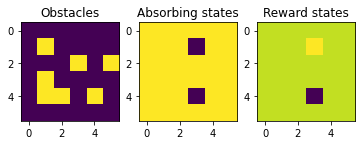

In [100]:
grid = GridWorld(p = 0.65)

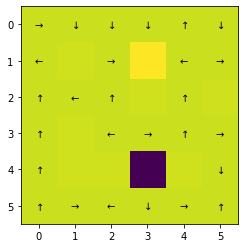

In [104]:
Q,opt_pol,learning = grid.mc_iterative(alpha = 0.4,discount = 0.7,epochs = 100)
grid.draw_deterministic_policy(np.array([np.argmax(opt_pol[row,:]) for row in range(grid.state_size)]))


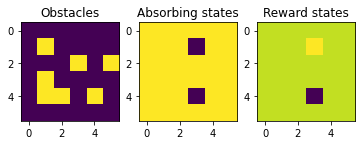

In [112]:
grid = GridWorld()
acc = np.zeros(100)
for i in range(100):
    Q,opt_pol,learning = grid.mc_iterative(alpha = 0.1,discount = 0.2,epochs = 100)
    acc += learning


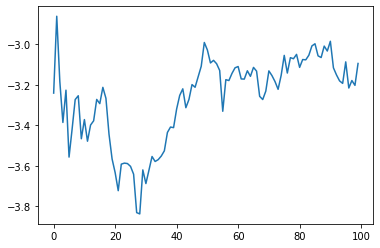

In [113]:
plt.plot(acc/100)

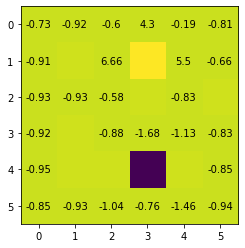

In [114]:
#val = np.max(Q,axis = 1)
val = np.sum(np.multiply(opt_pol,Q),axis = 1)
grid.draw_value(val)


Impact of gamma value on the number of epochs needed for the value iteration algorithm:



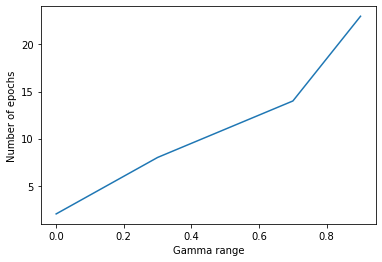


Graphical representation of the policy for each gamma:



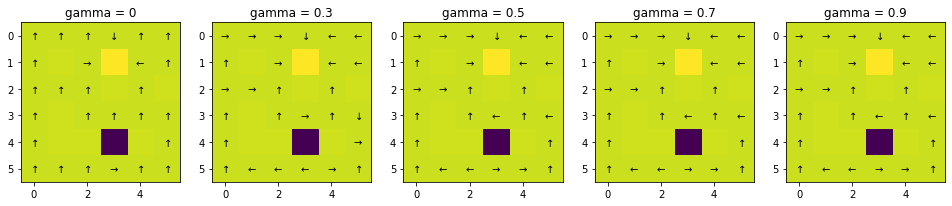


Graphical representation of the value function for each gamma:



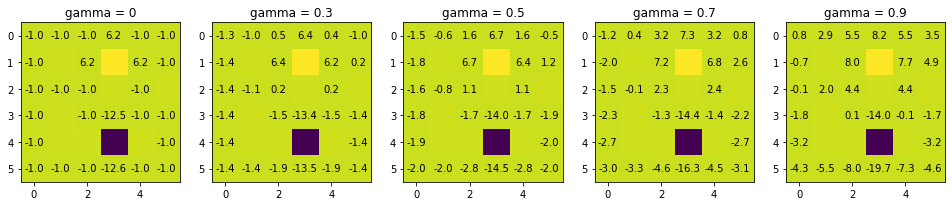

In [336]:
# Impact of gamma on the value iteration algorithm
gamma_range = [0, 0.3, 0.5, 0.7, 0.9]
epochs_needed = []
pols_needed = []
pols_title = []
vals_needed = []
vals_title = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    pol_opt2, epochs = grid.value_iteration(discount = gamma)
    val = grid.get_valuefunction()
    vals_needed.append(val)
    vals_title.append("gamma = {}".format(gamma))
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))
    pols_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all policies for different values of gamma
print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, pols_title, 1, 6)

# Print all value functions for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, vals_title, 2, 6)